In [1]:
import torch
import numpy as np
from globalbiopak.linop import *
from globalbiopak.phaseretrieval import ForwardPhaseRetrieval
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Random model

In [2]:
d = 200
n = 1000
x = torch.randn(d, dtype=torch.complex64)
A = torch.randn(n, d, dtype=torch.complex64)
op = LinOpMatrix(A)
forward = ForwardPhaseRetrieval(op)
y = forward.apply(x)

In [4]:
xest = forward.spectralinit(y)
xest.requires_grad = True
n_iter = 100
step = 1e-3
optimizer = torch.optim.SGD({xest}, lr=step, momentum=0.1, nesterov=True)

for i_iter in range(n_iter):
    optimizer.zero_grad()
    yest = forward.apply(xest)
    loss = torch.norm(yest-y)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    print("Final correlation (close to 1 means successful recovery):")
    print(torch.abs(xest.T.conj() @ x) / \
        torch.sqrt(torch.sum(torch.abs(x)**2)) / torch.sqrt(torch.sum(torch.abs(xest)**2)))

Final correlation (close to 1 means successful recovery):
tensor(0.9974)


# Coded Diffraction Imaging

In [11]:
d = 200
n_masks = 10
x = torch.randn(d, dtype=torch.complex64)
masks = torch.randn(n_masks, d, dtype=torch.complex64)
op = LinOpComposition(LinOpFFT(), LinOpMul(masks[0, :]))
for i in range(1, n_masks):
    op = StackLinOp(op, LinOpComposition(LinOpFFT(), LinOpMul(masks[i, :])))
forward = ForwardPhaseRetrieval(op)
y = forward.apply(x)

In [12]:
xest = forward.spectralinit(y)
xest.requires_grad = True
n_iter = 100
step = 1e-3
optimizer = torch.optim.SGD({xest}, lr=step, momentum=0.1, nesterov=True)

for i_iter in range(n_iter):
    optimizer.zero_grad()
    yest = forward.apply(xest)
    loss = torch.norm(yest-y)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    print("Final correlation (close to 1 means successful recovery):")
    print(torch.abs(xest.T.conj() @ x) / \
        torch.sqrt(torch.sum(torch.abs(x)**2)) / torch.sqrt(torch.sum(torch.abs(xest)**2)))

Final correlation (close to 1 means successful recovery):
tensor(0.9991)


# Ptychography

In [40]:
d = 500
n_img = 10
ptycho_radius = 250
left_origin = ptycho_radius / 2
right_origin = d - ptycho_radius / 2
step_size = int((right_origin - left_origin) / n_img)
overlap = 1 - step_size / ptycho_radius
print(f"The overlap is {overlap}")

sampling_grid = torch.linspace(0, d-1, d)
probe = torch.randn(d, dtype=torch.complex64) * (sampling_grid < ptycho_radius)

x = torch.randn(d, dtype=torch.complex64)
op = LinOpComposition(LinOpFFT(), LinOpMul(probe))
for i in range(1, n_masks):
    op = StackLinOp(op, LinOpComposition(LinOpFFT(), LinOpMul(torch.roll(probe, i*step_size))))
forward = ForwardPhaseRetrieval(op)
y = forward.apply(x)

The overlap is 0.9


In [42]:
xest = forward.spectralinit(y)
xest.requires_grad = True
n_iter = 1000
step = 1e-3
optimizer = torch.optim.SGD({xest}, lr=step, momentum=0.1, nesterov=True)

for i_iter in range(n_iter):
    optimizer.zero_grad()
    yest = forward.apply(xest)
    loss = torch.norm(yest-y)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    print("Final correlation (close to 1 means successful recovery):")
    print(torch.abs(xest.T.conj() @ x) / \
        torch.sqrt(torch.sum(torch.abs(x)**2)) / torch.sqrt(torch.sum(torch.abs(xest)**2)))

Final correlation (close to 1 means successful recovery):
tensor(0.9751)


# CryoEM ptychography

/home/jdong/.conda/envs/tomosipo2/lib/python3.8/site-packages/tomosipo/links/torch.py:63: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  warnings.warn(


Size of the input data: torch.Size([200, 200])


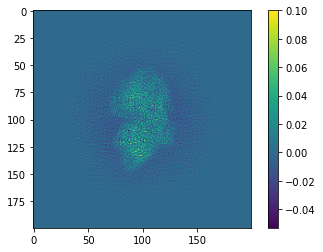

In [7]:
from globalbiopak.dataloader import loaddata
proj = loaddata('cryoEM')
print(f"Size of the input data: {proj.shape}")

phase_scale = 0.1
proj = proj / torch.amax(proj, dim=(0,1))
obj = torch.exp(1j * proj * phase_scale)
plt.imshow(torch.angle(obj))
plt.colorbar();

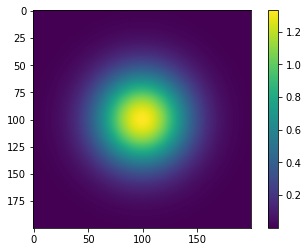

In [16]:
size = proj.shape[0]
x_grid = torch.linspace(-1, 1, size)
y_grid = torch.linspace(-1, 1, size)
x_grid2d, y_grid2d = torch.meshgrid(x_grid, y_grid)

probe_radius = 0.3
probe = 1 / np.sqrt(2*np.pi*probe_radius**2) * torch.exp(
    - 1 / 2 / probe_radius**2 * 
    (x_grid2d**2 + y_grid2d**2))
plt.imshow(probe)
plt.colorbar();

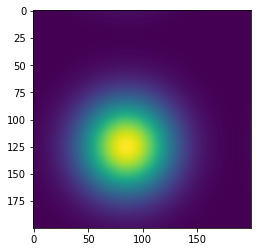

In [17]:
shift_scale = 0.5
probe_xpos = [-0.5, 0, 0.5]
probe_ypos = [-np.sqrt(3)/6, np.sqrt(3)/3, -np.sqrt(3)/6]
probe_nbr = len(probe_xpos)
probe_stack = torch.empty(size, size, probe_nbr)
for i_probe in range(probe_nbr):
    shift_x = int(probe_xpos[i_probe] * size / 2 * shift_scale)
    shift_y = int(probe_ypos[i_probe] * size / 2 * shift_scale)
    probe_stack[:, :, i_probe] = torch.roll(
        probe, shifts=(shift_x, shift_y), dims=(0,1))
plt.imshow(probe_stack[:,:,2])

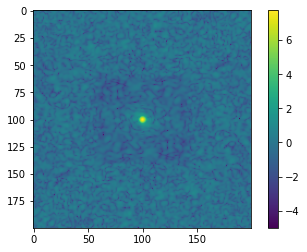

In [23]:
intensities = torch.empty(size, size, probe_nbr)
for i_probe in range(probe_nbr):
    field = probe_stack[:, :, i_probe] * obj
    fourier_field = torch.fft.fft2(field)  # no fftshift because of modulus after
    intensities[:, :, i_probe] = torch.abs(fourier_field)**2
plt.imshow(torch.log10(torch.fft.fftshift(intensities[:, :, 0])))
plt.colorbar();

torch.Size([600, 200])


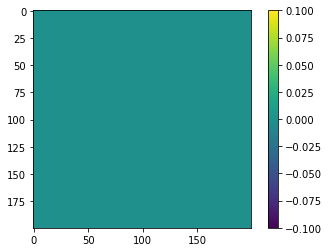

In [51]:
fft2_op = LinOpFFT2()
probe_mult = LinOpMul(probe_stack[:, :, 0])
ptycho_op = LinOpComposition(fft2_op, probe_mult)
for i_probe in range(1, probe_nbr):
    probe_mult = LinOpMul(probe_stack[:, :, i_probe])
    ptycho_op = StackLinOp(ptycho_op, 
        LinOpComposition(fft2_op, probe_mult))
forward = ForwardPhaseRetrieval(ptycho_op)
y = forward.apply(obj)
# fourier_field = ptycho_op.apply(obj)
# y = torch.abs(fourier_field)**2
print(y.shape)
# Not the best way to stack LinOp for 2D objects
# Important to fix it before using spectral methods
plt.imshow((torch.fft.fftshift(y[:200, :]-intensities[:, :, 0])))
plt.colorbar();

In [69]:
xest = forward.spectralinit(y, n_iter=200, method="Lu")
xest = xest / torch.abs(xest)
xest.requires_grad = True
n_iter = 1000
step = 1e-6
optimizer = torch.optim.SGD({xest}, lr=step, momentum=0.1, nesterov=True)

for i_iter in range(n_iter):
    optimizer.zero_grad()
    yest = forward.apply(xest)
    # fourier_field = ptycho_op.apply(xest)
    # yest = torch.abs(fourier_field)**2
    loss = torch.norm(yest-y)
    loss.backward()
    optimizer.step()


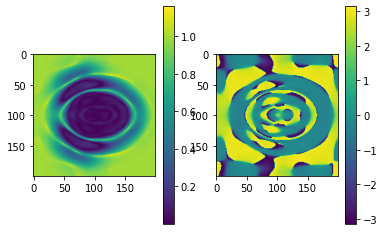

In [68]:
plt.subplot(1,2,1)
plt.imshow(torch.abs(xest.detach()))
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(torch.angle(xest.detach()))
plt.colorbar();